# Community detection in networks

Community detection is a fundamental problem in network analysis. It refers to the task of identifying groups of nodes in a network that are more densely connected to each other than to the rest of the network. These groups are called communities or clusters. Communities are useful for understanding the structure and function of networks, as they reveal patterns of connectivity that are not apparent from the global structure of the network.

Roughly speaking, a community is a group of nodes that are more densely connected to each other than to the rest of the network. There are many ways to define and detect communities in networks, and different methods may produce different results. In this notebook, we will explore some common methods for community detection in networks, including modularity maximization, spectral clustering, and hierarchical clustering.

It is possible to divide the methods for community detection into two main categories: Agglomirative and Divisive. The agglomerative methods start with each node in its own community and then merge communities together until some stopping criterion is met. The divisive methods start with all nodes in a single community and then split communities apart until some stopping criterion is met.


Examples of agglomerative methods are:
- Modularity maximization
- Label propagation
- Louvain method


Examples of divisive methods:
- Girvan-Newman method


The code below shows the basic steps for community detection in a network. Each of these algorithms have ready-to-use implementations in `networkx`, but we will implement them from scratch to understand how they work.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
g_karate = nx.karate_club_graph()
pos = nx.spring_layout(g_karate)

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph(g, pos=None, with_labels=True, node_size_attribute=None, edge_weight_attribute=None, communities=None, ax=None, alpha=1):
    """
    Plot a graph with nodes colored by community and node sizes and edge widths based on attributes.
    
    Parameters:
    g (networkx.Graph): The input graph.
    pos (dict): A dictionary of node positions.
    node_size_attribute (str): The node attribute to determine node sizes.
    edge_weight_attribute (str): The edge attribute to determine edge widths.
    communities (list of lists): A list of communities, where each community is a list of nodes.
    ax (matplotlib.Axes): The matplotlib Axes object to draw the plot.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    if pos is None:
        pos = nx.spring_layout(g)
    
    # Set node sizes based on the attribute
    if node_size_attribute:
        node_sizes = [g.nodes[node].get(node_size_attribute, 300) * 100 for node in g.nodes()]
    else:
        node_sizes = 300

    # Set edge widths based on the attribute
    if edge_weight_attribute:
        edge_widths = [g.edges[edge].get(edge_weight_attribute, 1) for edge in g.edges()]
    else:
        edge_widths = 1
    
    if communities is None:
        nx.draw(g, pos, with_labels=with_labels, ax=ax, node_size=node_sizes, width=edge_widths, alpha=alpha)
    else:
        for i, community in enumerate(communities):
            nx.draw_networkx_nodes(g, pos, nodelist=community, node_color=f'C{i}', ax=ax, node_size=node_sizes, alpha=alpha)
        nx.draw_networkx_edges(g, pos, ax=ax, width=edge_widths)
        nx.draw_networkx_labels(g, pos, ax=ax)
    
    ax.grid(False)
    return ax


<Axes: >

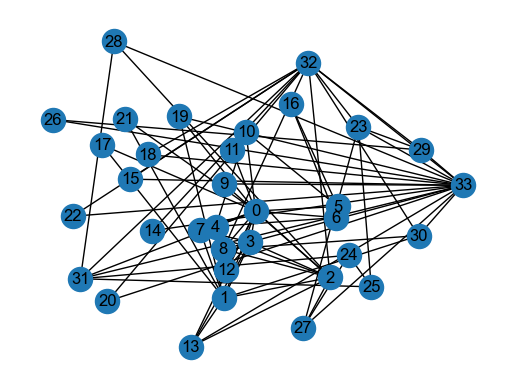

In [53]:
plot_graph(g_karate, pos)

## Agglomirative methods

### Modularity maximization

Modularity of a network is a measure of the quality of a community structure. It is defined as the fraction of the edges that fall within communities minus the expected fraction of edges if the edges were distributed at random. The modularity of a network can be computed using the following formula:

$$Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)$$

Modularity maximization is a popular method for community detection in networks. The idea is to find a partition of the network that maximizes the modularity. This can be done using a greedy algorithm that iteratively merges communities to maximize the modularity. The algorithm works as follows:

1.	Initialization: Start with each node in its own community.
2.	Calculate Modularity Gain: For each pair of communities, calculate the gain in modularity if they were merged.
3.	Merge Communities: Merge the pair of communities that results in the highest modularity gain.
4.	Repeat: Repeat steps 2 and 3 until no further increase in modularity is possible or a specified number of communities is reached.


In [5]:
def compute_modularity(G, communities):
    """
    Compute the modularity of a partition of a graph.
    
    Parameters:
    G (networkx.Graph): The input graph.
    communities (list of lists): A list of communities, where each community is a list of nodes.
    
    Returns:
    float: The modularity score.
    """
    m = G.number_of_edges()
    A = nx.to_numpy_array(G)
    degrees = dict(G.degree())
    Q = 0
    
    for community in communities:
        for i in community:
            for j in community:
                Q += A[i, j] - degrees[i] * degrees[j] / (2 * m)
    
    return Q / (2 * m)

The function `compute_modularity` takes a graph `G` and a list of communities `communities` as input and computes the modularity of the partition defined by the communities. It uses the formula for modularity to calculate the modularity score. We can claim that each node is a cluster of its own, and compute the modularity of this initial partition.

In [7]:
from IPython.core.display_functions import clear_output
from itertools import combinations


def maximize_modularity(G, communities = None, plot_every_n_steps = 10):
    """
    Greedy algorithm to maximize the modularity of the graph partition.
    
    Parameters:
    G (networkx.Graph): The input graph.
    
    Returns:
    tuple: A tuple containing the list of communities and the corresponding modularity scores.
    """
    # Initialize each node in its own community
    if communities is None:
        communities = [[node] for node in G.nodes]
    modularity_scores = [compute_modularity(G, communities)]
    count = 0
    while True:
        best_increase = 0
        best_pair = None
        # Evaluate all possible pairs of communities to merge
        for c1, c2 in combinations(communities, 2):
            new_communities = [c for c in communities if c != c1 and c != c2] + [c1 + c2]
            new_modularity = compute_modularity(G, new_communities)
            increase = new_modularity - modularity_scores[-1]
            
            if increase > best_increase:
                best_increase = increase
                best_pair = (c1, c2)
        
        # Stop if no modularity increase is possible
        if best_increase <= 0:
            break
        
        # Merge the best pair of communities
        c1, c2 = best_pair
        communities = [c for c in communities if c != c1 and c != c2] + [c1 + c2]
        modularity_scores.append(compute_modularity(G, communities))
    
        if count % plot_every_n_steps == 0:
            ax = plot_graph(G, pos, communities)
            ax.set_title(f'After step {count}: Modularity = {modularity_scores[-1]:.3f}')
        count += 1
            
    return communities, modularity_scores

# Maximize modularity and get the communities and scores
final_communities, modularity_scores = maximize_modularity(g, plot_every_n_steps=10)
fig, ax = plt.subplots()
ax.plot(modularity_scores)

NameError: name 'g' is not defined

### Label propagation

Label propagation is a simple and efficient algorithm for community detection in networks. The idea is to assign a label to each node and then propagate the labels through the network until a stable state is reached. The algorithm works as follows:

1. **Initialization**: Assign a unique label to each node.
2. **Label Update**: For each node, update its label to the most frequent label among its neighbors. If there is a tie, choose one label randomly.
3. **Repeat**: Repeat the label update process until no more changes occur in the labels of the nodes.

This algorithm is fast and scales well to large networks, making it a popular choice for community detection. It often produces good results, particularly in networks with a clear community structure.

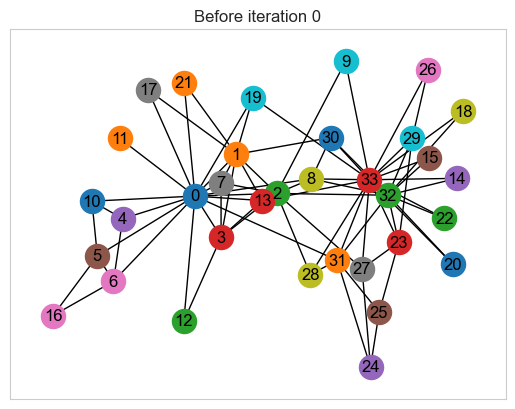

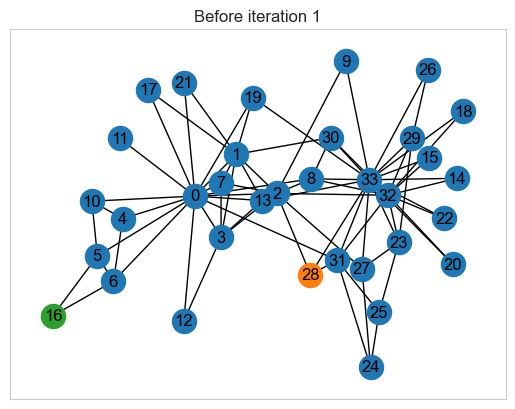

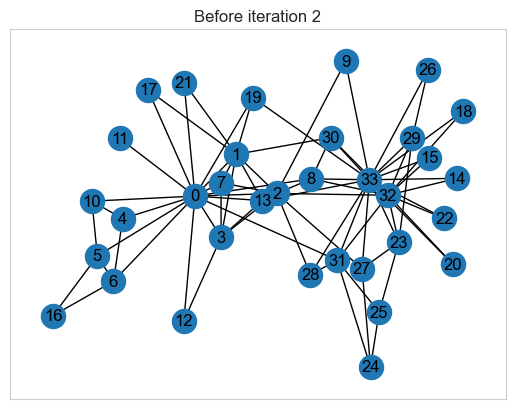

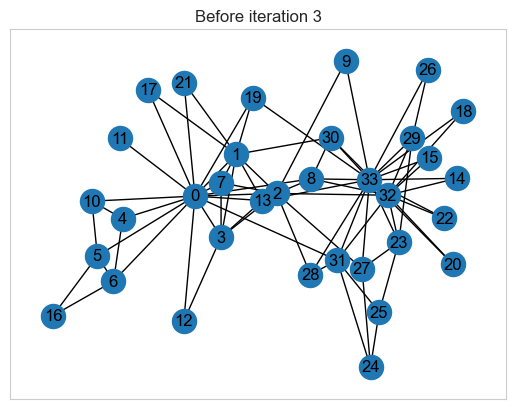

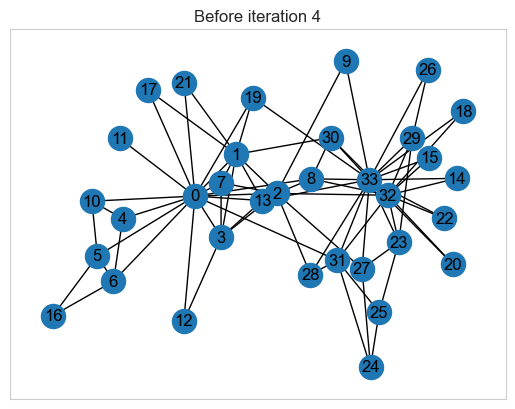

In [8]:
def label_propagation(G, labels=None, max_iters=100, plot_every_n_steps=10):
    """
    Label propagation algorithm for community detection.
    
    Parameters:
    G (networkx.Graph): The input graph.
    max_iters (int): The maximum number of iterations to run.
    
    Returns:
    list of lists: A list of communities, where each community is a list of nodes.
    """
    
    if labels is None:
        labels = {node: node for node in G.nodes}
    for iteration in range(max_iters):
        if iteration % plot_every_n_steps == 0:
            communities = {label: [] for label in set(labels.values())}
            for node, label in labels.items():
                communities[label].append(node)
            communities = list(communities.values())
            ax = plot_graph(G, pos, communities=communities)
            ax.set_title(f'Before iteration {iteration}')
        nodes = list(G.nodes)
        np.random.shuffle(nodes)
        for node in nodes:
            neighbors = list(G.neighbors(node))
            neighbor_labels = [labels[n] for n in neighbors]
            label_counts = np.bincount(neighbor_labels)
            new_label = np.argmax(label_counts)
            labels[node] = new_label
        
    communities = {label: [] for label in set(labels.values())}
    for node, label in labels.items():
        communities[label].append(node)
    return list(communities.values())
communities = label_propagation(g_karate, max_iters=5, plot_every_n_steps=1)

### Louvain Method

Louvain method is a popular method for community detection in networks. The idea is to optimize a quality function called modularity that measures the strength of the division of a network into communities. The algorithm works as follows:

1. **Initialization**: Assign each node to its own community, resulting in `n` communities for `n` nodes.
2. **Local Modularity Optimization**: For each node, move it to the community of one of its neighbors if this move increases the overall modularity. This step is repeated for all nodes until no further improvement can be made.
3. **Community Aggregation**: Aggregate the graph by creating a new network where nodes represent communities discovered in the previous step, and edges represent the sum of edges between nodes in the original graph. 
4. **Repeat**: Apply the local modularity optimization to the aggregated graph. This process of local optimization and aggregation is repeated until the modularity cannot be improved further.

The Louvain method is efficient and scalable, making it suitable for large networks. It often produces high-quality community structures that maximize modularity.

Unfortunately, its implementation is not straightforward, so we will not implement it from scratch. Instead, we will use the implementation provided by the `networkx` library.

<Axes: >

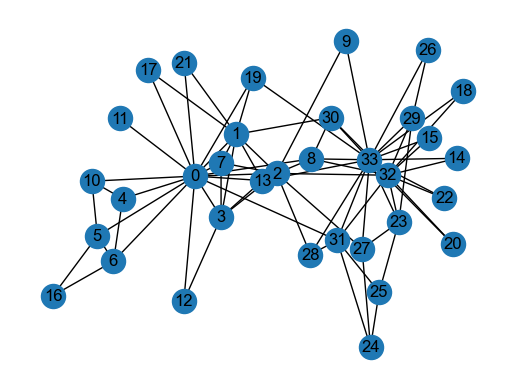

In [9]:
from networkx.algorithms.community import louvain_communities
communities = list(louvain_communities(g_karate))
plot_graph(g_karate, pos, communities)

Let's see a slightly more complex example.

<Axes: >

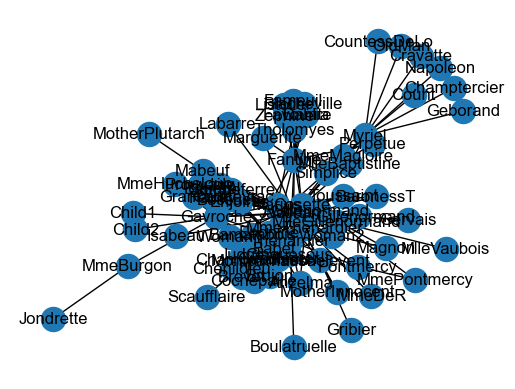

In [10]:
g_hugo = nx.les_miserables_graph()  # graph of characters in Les Miserables
pos_hugo = nx.spring_layout(g_hugo)
communities = list(louvain_communities(g_hugo))
plot_graph(g_hugo, pos_hugo, communities)

## Divisive methods

While agglomerative methods start with each node in its own community and merge communities together, divisive methods start with all nodes in a single community and split communities apart. The Girvan-Newman method is a popular divisive method for community detection in networks. The idea is to iteratively remove edges from the network based on edge betweenness centrality until the network is divided into communities. The algorithm works as follows:

1.	Initialization: Start with all nodes in a single community.
2.	Edge Betweenness Calculation: Calculate the betweenness centrality of all edges in the network.
3.	Edge Removal: Remove the edge with the highest betweenness centrality.
4.	Community Detection: Recalculate the connected components of the network to identify the communities.
5.	Repeat: Repeat steps 2-4 until the desired number of communities is reached or until no edges remain.
6.	Final Community Detection: The connected components of the network at the end of the process represent the communities.


In [11]:
def remove_highest_betweenness_edge(G):
    """
    Remove the edge with the highest betweenness centrality.
    
    Parameters:
    G (networkx.Graph): The input graph.
    
    Returns:
    networkx.Graph: The graph after removing the edge with the highest betweenness centrality.
    """
    edge_betweenness = nx.edge_betweenness_centrality(G)
    edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
    G.remove_edge(*edge_to_remove)
    return G

In [12]:
def girvan_newman_algorithm(G, num_communities):
    """
    Perform the Girvan-Newman algorithm to detect communities in the graph.
    
    Parameters:
    G (networkx.Graph): The input graph.
    num_communities (int): The desired number of communities.
    
    Returns:
    list of sets: A list where each set contains the nodes in one community.
    """
    # Make a copy of the graph to avoid modifying the original graph
    G_copy = G.copy()
    
    # Keep removing edges until the desired number of communities is reached
    while nx.number_connected_components(G_copy) < num_communities:
        G_copy = remove_highest_betweenness_edge(G_copy)
    
    # Get the connected components as communities
    communities = list(nx.connected_components(G_copy))
    
    return communities


<Axes: >

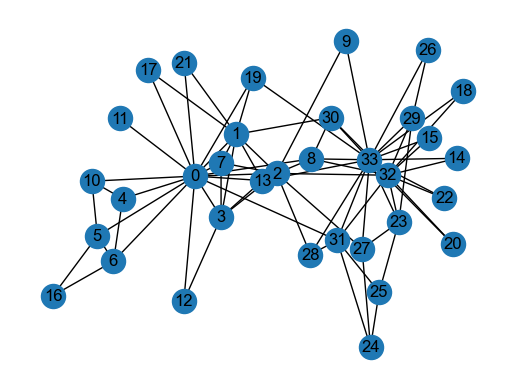

In [13]:
communities =girvan_newman_algorithm(g_karate, 2)
plot_graph(g_karate, pos, communities)

<Axes: >

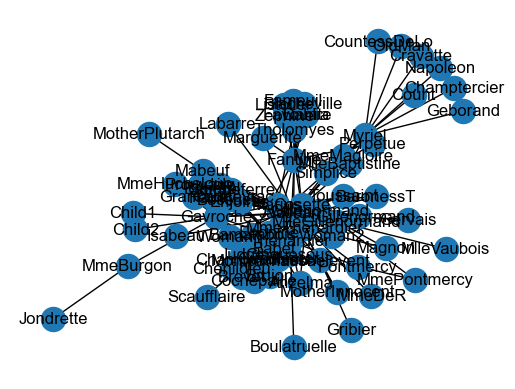

In [14]:
communities_hugo = girvan_newman_algorithm(g_hugo, 5)
plot_graph(g_hugo, pos_hugo, communities_hugo)

<Axes: >

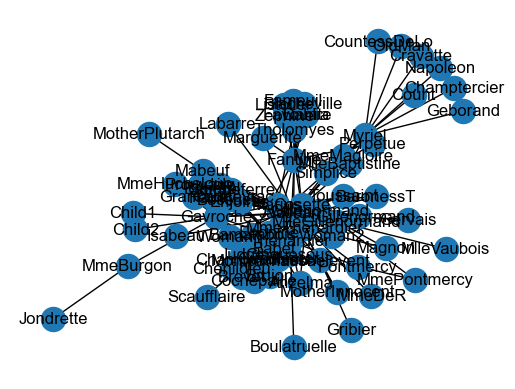

In [15]:
communities_hugo = girvan_newman_algorithm(g_hugo, 2)
plot_graph(g_hugo, pos_hugo, communities_hugo)

Many community detection algorithsm accept various parameters. For example, Newman Girvan accept the number of communities. Other algorithms accept the resolution parameter, which controls the size of the communities.  How do we decide the best parameters for a given network? One common approach is to use a measure called the modularity, which quantifies the quality of a community structure. The modularity of a network is a measure of the quality of a community structure. It is defined as the fraction of the edges that fall within communities minus the expected fraction of edges if the edges were distributed at random. 

In [16]:
def scan_n_communities_modularity(G, n_max=6, ax = None ):
    G = G.copy()
    # replace string node ids with integers
    mapping = {node: i for i, node in enumerate(G.nodes)}
    G = nx.relabel_nodes(G, mapping)
    modularity_values = []
    for n_communities in range(1, n_max):
        communities = girvan_newman_algorithm(G, n_communities)
        modularity = compute_modularity(G, communities)
        modularity_values.append([n_communities, modularity])
    modularity_values = np.array(modularity_values)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(modularity_values[:, 0], modularity_values[:, 1])
    ax.set_xticks(modularity_values[:, 0])
    return ax


Text(0.5, 1.0, 'Modularity as a function of the number of communities, Karate Club')

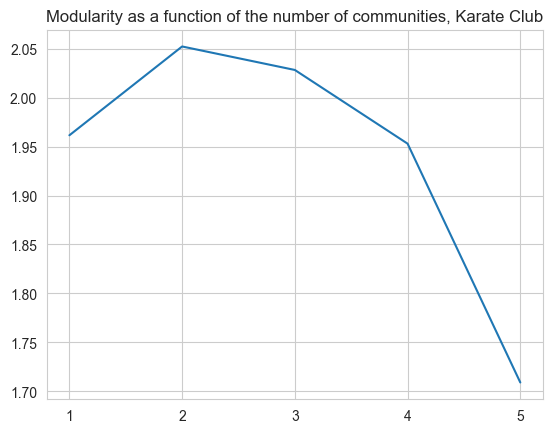

In [17]:
ax = scan_n_communities_modularity(g_karate)
ax.set_title('Modularity as a function of the number of communities, Karate Club')

The graph above shows the modularity values for different numbers of communities. We can use this graph to choose the number of communities that maximize the modularity. In this case, the modularity is maximized when the number of communities is 2, which is consistent with the ground truth in this case.

Text(0.5, 1.0, 'Modularity as a function of the number of communities, Les Miserables')

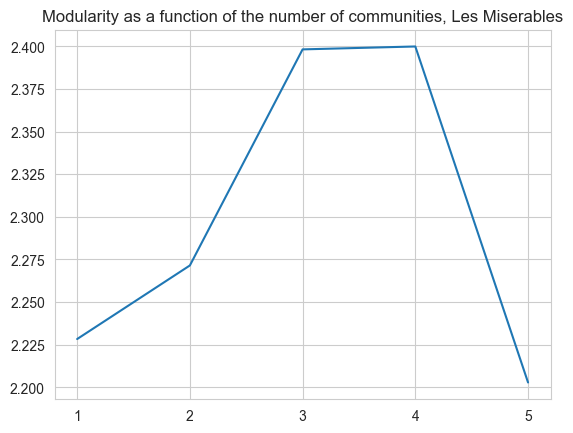

In [18]:
ax = scan_n_communities_modularity(g_hugo)
ax.set_title('Modularity as a function of the number of communities, Les Miserables')


Here, the modularity is maximized when the number of communities is 3 or 4

Text(0.5, 1.0, 'Modularity as a function of the number of communities, Barabasi-Albert')

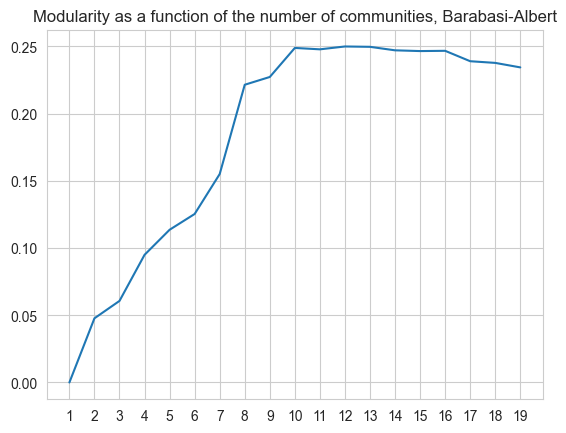

In [19]:
g_large = nx.barabasi_albert_graph(75, 3)
ax = scan_n_communities_modularity(g_large, n_max=20)
ax.set_title('Modularity as a function of the number of communities, Barabasi-Albert')

<Axes: >

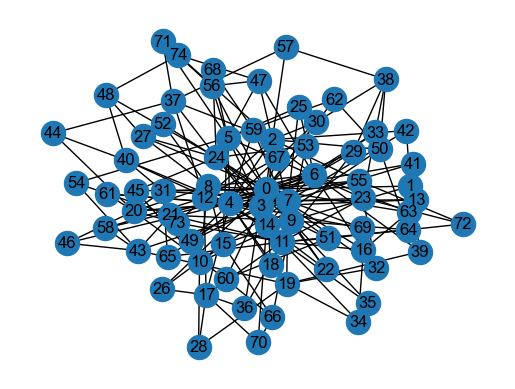

In [30]:
n_communities = 13
communities = girvan_newman_algorithm(g_large, n_communities)
pos_large = nx.spring_layout(g_large)
plot_graph(g_large, pos_large, communities)

Another method to evaluate the quality of a community structure is to use the silhouette score, which measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score can be used to compare different community structures and choose the one that maximizes the quality of the clustering.

In [21]:
from sklearn.metrics import silhouette_score
def compute_silhouette_score(G, communities):
    """
    Compute the silhouette score of a partition of a graph.
    
    Parameters:
    G (networkx.Graph): The input graph.
    communities (list of lists): A list of communities, where each community is a list of nodes.
    
    Returns:
    float: The silhouette score.
    """
    labels = np.zeros(G.number_of_nodes())
    for i, community in enumerate(communities):
        for node in community:
            labels[node] = i
    A = nx.to_numpy_array(G)
    return silhouette_score(A, labels)


In [22]:
def scan_n_communities_silhouette(G, n_max=6, ax = None ):
    G = G.copy()
    # replace string node ids with integers
    mapping = {node: i for i, node in enumerate(G.nodes)}
    G = nx.relabel_nodes(G, mapping)
    silhouette_values = []
    for n_communities in range(2, n_max):
        communities = girvan_newman_algorithm(G, n_communities)
        silhouette = compute_silhouette_score(G, communities)
        silhouette_values.append([n_communities, silhouette])
    silhouette_values = np.array(silhouette_values)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(silhouette_values[:, 0], silhouette_values[:, 1])
    ax.set_xticks(silhouette_values[:, 0])
    return ax

Text(0.5, 1.0, 'Silhouette score as a function of the number of communities, Karate Club')

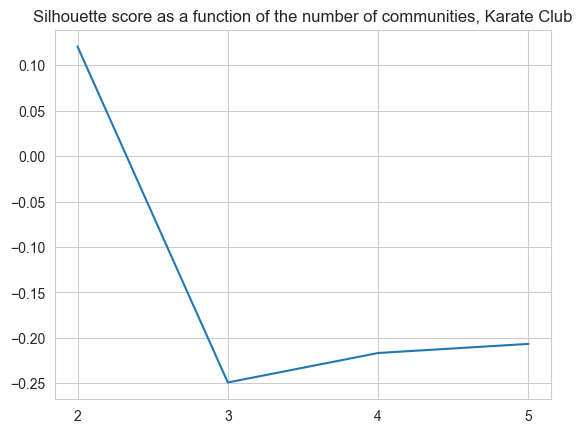

In [23]:
ax = scan_n_communities_silhouette(g_karate)
ax.set_title('Silhouette score as a function of the number of communities, Karate Club')

Here, we are looking for a breaking point. It occurs between 2 and 3 communities.

Text(0.5, 1.0, 'Silhouette score as a function of the number of communities, Les Miserables')

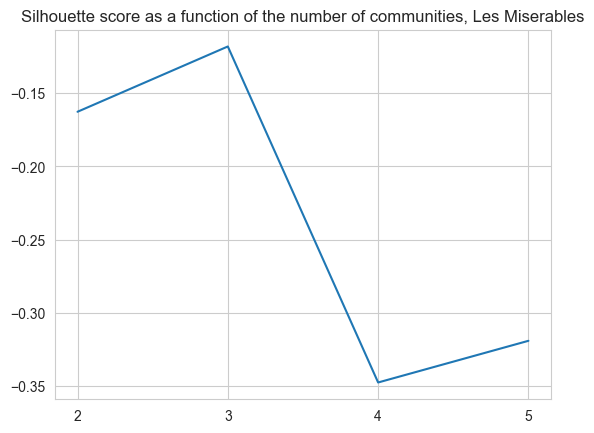

In [24]:
ax = scan_n_communities_silhouette(g_hugo)
ax.set_title('Silhouette score as a function of the number of communities, Les Miserables')

Text(0.5, 1.0, 'Silhouette score as a function of the number of communities, Barabasi-Albert')

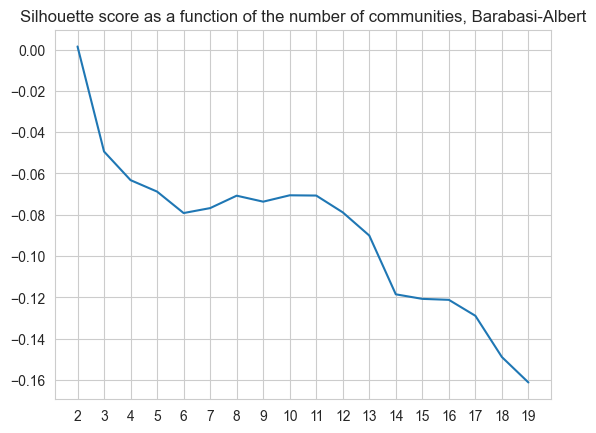

In [25]:
ax = scan_n_communities_silhouette(g_large, n_max=20)
ax.set_title('Silhouette score as a function of the number of communities, Barabasi-Albert')

## Communities as nodes

Sometimes it is useful to represent communities as nodes in a new graph, where the edges between communities represent the number of edges between the corresponding communities in the original graph. This can help to visualize the structure of the network at a higher level of abstraction and identify patterns of connectivity between communities.

In [27]:
def communities_as_nodes(G, communities, pos=None):
    """
    Represent communities as nodes in a new graph, where the edges between communities 
    represent the number of edges between the corresponding communities in the original graph.
    
    Parameters:
    G (networkx.Graph): The original graph.
    communities (list of lists): A list of communities, where each community is a list of nodes.
    
    Returns:
    networkx.Graph: A new graph where each node represents a community from the original graph.
    """
    g_new = nx.Graph()
    
    # Add nodes representing communities with size attribute
    for community in communities:
        g_new.add_node(tuple(community), size=len(community))
    if pos is not None:
        # compute x and y of the new nodes as the average of the positions of the nodes in the community
        pos_new = {tuple(community): np.mean([pos[node] for node in community], axis=0) for community in communities}
        # assign the new positions to the nodes in `x` and `y` attributes
        nx.set_node_attributes(g_new, pos_new, 'pos')
    
    # Add weighted edges between communities
    for i, community1 in enumerate(communities):
        for j, community2 in enumerate(communities):
            if i < j:
                # Count the number of edges between nodes in community1 and community2
                weight = 0
                for node1 in community1:
                    for node2 in community2:
                        if G.has_edge(node1, node2):
                            weight += 1
                if weight > 0:
                    g_new.add_edge(tuple(community1), tuple(community2), weight=weight)
    
    return g_new


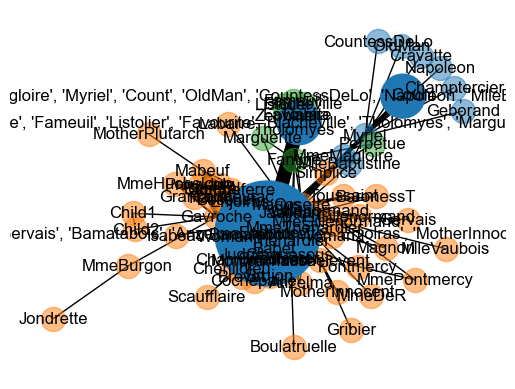

In [66]:
communities_hugo = girvan_newman_algorithm(g_hugo, 3)
g_new = communities_as_nodes(g_hugo, communities_hugo, pos=pos_hugo)
pos_new = {node: g_new.nodes[node].get('pos', np.random.rand(2)) for node in g_new.nodes}
ax = plt.gca()
plot_graph(g_hugo, pos_hugo, communities=communities_hugo, ax=ax, alpha=0.5, with_labels=False)
ax = plot_graph(g_new, pos_new, node_size_attribute='size', edge_weight_attribute='weight', with_labels=True, ax=ax)

<Axes: >

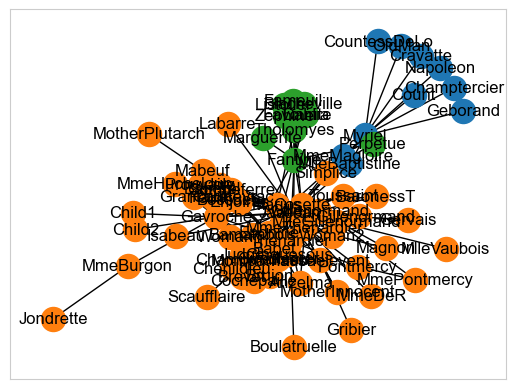

In [67]:
plot_graph(g_hugo, pos_hugo, communities=communities_hugo)

<Axes: >

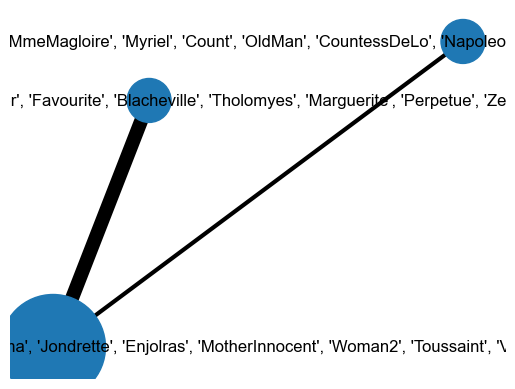

In [68]:
plot_graph(g_new, pos_new, node_size_attribute='size', edge_weight_attribute='weight', with_labels=True)

In [60]:
communities_hugo = girvan_newman_algorithm(g_hugo, 13)


KeyError: 'N'

In [43]:
pos_new[0]

array([ 0.07121678, -0.07852757])

## Further reading
* An excelent paper [A Comparative Analysis of Community Detection Algorithms on Artificial Networks](https://www.nature.com/articles/srep30750). Among other topics, this paper discusses the choice of optimal parameters in community detection algorithms.
* [Community detection in social networks](https://www.researchgate.net/publication/295395520_Community_detection_in_social_networks) -- another excellent review, shorter than the previous one.
* [Social Network Analysis: Community Detection](https://towardsdatascience.com/social-network-analysis-community-detection-2b19e836c76c). This post uses R, but the concepts are the same.
